# Attempts at minimalistic flow modeling

Links:
* Solving for pressure (making fluid incompressible): https://www.karlsims.com/fluid-flow.html
* Moving the fluid (See subtitle "Stam's Advection"): https://www.gamasutra.com/view/feature/1549/practical_fluid_dynamics_part_1.php?print=1
* https://www.researchgate.net/publication/27293557_Interacting_with_smoke_and_Fire_in_real_time

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

In [153]:
def shift(a, axis=0):
    """Utility function for the future: shift all rows or cols in a matrix by 1, padding with 0s"""
    if axis==0:
        n = a.shape[1]
        return np.concatenate((np.zeros((1,n)), a[:-1,:]), axis=0)
    if axis==1:
        n = a.shape[0]
        return np.concatenate((np.zeros((n,1)), a[:,:-1]), axis=1)
    
print(shift(np.array([[1,2,3], [4,5,6]]), axis=0))
print(shift(np.array([[1,2,3], [4,5,6]]), axis=1))

[[0. 0. 0.]
 [1. 2. 3.]]
[[0. 1. 2.]
 [0. 4. 5.]]


In [167]:
# Test 2d convolutions
a = np.zeros((6,6))
a[1,2] = 1
a[3,5] = 1
print(a)

b = np.array([[0,1,0], [1,2,3], [0,-1,0]])

print(sig.convolve2d(a, b, mode='same'))
# Note that convolution is not reversed

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  2.  3.  0.  0.]
 [ 0.  0. -1.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  2.]
 [ 0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.]]


In [260]:
# Calculated advection

def interp(f, x, y):
    """Bilinearly interpolate within matrix f, using real x and y (like i,j, but fractional).
    Ref: https://en.wikipedia.org/wiki/Bilinear_interpolation """
    if x<0 or x>f.shape[0]-1 or y<0 or y>f.shape[1]-1:
        return 0 # Eternal winter outside (no interpolation if out of bounds)
    i = np.floor(x).astype(int) # Whole part
    j = np.floor(y).astype(int)
    i = min(i, f.shape[0]-2) # For the interpolation formula to work, we cannot be on the right border
    j = min(j, f.shape[1]-2)
    return f[i,j]*(i+1-x)*(j+1-y) + f[i+1,j]*(x-i)*(j+1-y) + f[i,j+1]*(i+1-x)*(y-j) + f[i+1,j+1]*(x-i)*(j-1)

def advect(field, vx, vy):
    """Advect the field using vx and vy local fluid speeds."""
    val = np.zeros(field.shape)
    for i in range(field.shape[0]):
        for j in range(field.shape[1]):
            # print(f"({i},{j})<--({i-vx[i,j]},{j-vy[i,j]}))")
            val[i,j] = interp(field, i-vx[i,j], j-vy[i,j])
    return val

a = np.array([[1,1,0],[1,1,0],[0,0,0]])
vx = np.array([[0,0,0],[0,1,1],[0,1,0]])
vy = np.zeros(vx.shape)
print('Field:\n',a)
print(interp(a, 1.1, 1.1))
advect(a, vx, vy)

Field:
 [[1 1 0]
 [1 1 0]
 [0 0 0]]
0.8099999999999998


array([[1., 1., 0.],
       [1., 1., 0.],
       [0., 1., 0.]])

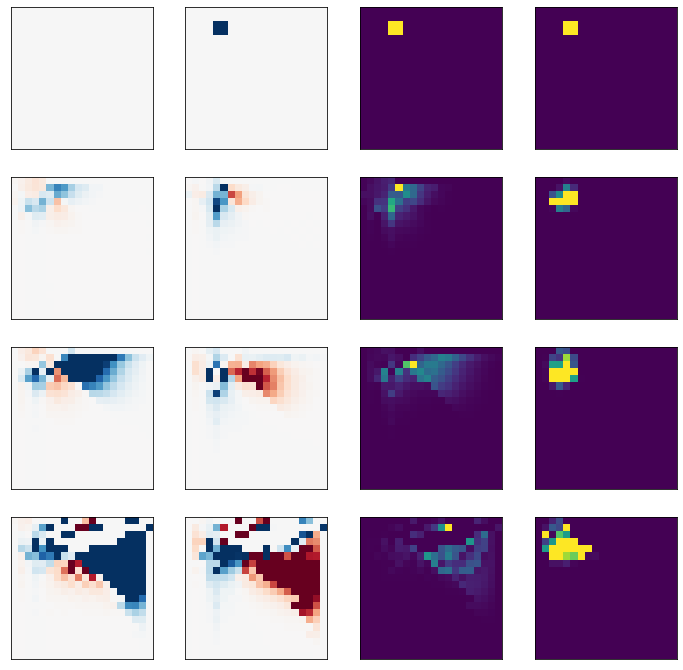

In [277]:
ngrid = 20          # Grid Dimensions
pcycles = 50        # How many pressure cycles to run on one advection cycle (50?)
alpha = 0.1         # Relaxation rate
viscosity =  0.1

vx = np.zeros((ngrid,ngrid)) # Speed components
vy = np.zeros((ngrid,ngrid))

vx[2:4,4:6] = 0     # Give the fluid a starting push
vy[2:4,4:6] = 1

field = np.zeros((ngrid,ngrid)) # Color fluid
field = vy.copy()

# A sequence of convolutions to calculate divergence:
divmask = np.array([[[ 1,-2, 1],
                     [ 2,-4, 2],
                     [ 1,-2, 1]], 
                    [[-1, 0, 1],
                     [ 0, 0, 0],
                     [ 1, 0,-1]], 
                    [[ 1, 2, 1],
                     [-2,-4,-2],
                     [ 1, 2, 1]]])/8 # xx, xy, yy (yx is the same as xx)
#viskmask = [[1,2,1],[2,-12,2],[1,2,1]]
viskmask = np.array([[1,1,1],[1,-8,1],[1,1,1]])/16

ntime = 8
nplots = 4
plotcount = 0
fig = plt.figure(figsize=(12,12))
for t in range(ntime):    
    if t % (np.ceil(ntime/nplots)) == 0:
        ax = plt.subplot(nplots, 4, 1 + 4*plotcount)
        plt.imshow(vx, cmap='RdBu') # --- Plotting speed of movement
        plt.clim(-1,1) # Color limits  
        plt.xticks([])
        plt.yticks([])
        
        ax = plt.subplot(nplots, 4, 2 + 4*plotcount)
        plt.imshow(vy, cmap='RdBu') # --- Plotting speed of movement
        plt.clim(-1,1) # Color limits  
        plt.xticks([])
        plt.yticks([])
        
        ax = plt.subplot(nplots, 4, 3 + 4*plotcount)
        plt.imshow(np.sqrt(np.square(vx) + np.square(vy))) # --- Plotting speed of movement
        plt.xticks([])
        plt.yticks([])
        
        ax = plt.subplot(nplots, 4, 4 + 4*plotcount)
        plt.imshow(field) # --- Plotting speed of movement
        plt.clim(0,1) # Color limits  
        plt.xticks([])
        plt.yticks([])
        
        plotcount += 1
    
    # Remove divergence (aka pressure-solver), and add some viscosity
    for q in range(pcycles):
        vx = vx + (sig.convolve2d(vx, divmask[0], mode='same') + 
                   sig.convolve2d(vy, divmask[1], mode='same') + 
                   sig.convolve2d(vx, viskmask, mode='same')*viscosity)*alpha
        vy = vy + (sig.convolve2d(vy, divmask[2], mode='same') + 
                   sig.convolve2d(vx, divmask[1], mode='same') + 
                   sig.convolve2d(vx, viskmask, mode='same')*viscosity)*alpha
    
    # Advection, Stam's algorithm, even if manual and slow
    field = advect(field, vx, vy)
    (vx, vy) = (advect(vx, vx, vy), advect(vy, vx, vy))
    
    #field = field*(1 - vx + vx[:,:-1]) # Define matrix shift and use it here